In [1]:
# MLP

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
# DSP data
fpath = "../../data/DNN_data/"

sig = np.load(fpath + "data_signal" + ".npy")
sig_with_artifact = np.load(fpath + "data_signal_with_sine" + ".npy")
artifact = sig_with_artifact - sig

sig_with_artifact.shape

(1000, 4000)

Text(0.5, 1.0, 'Original Signal')

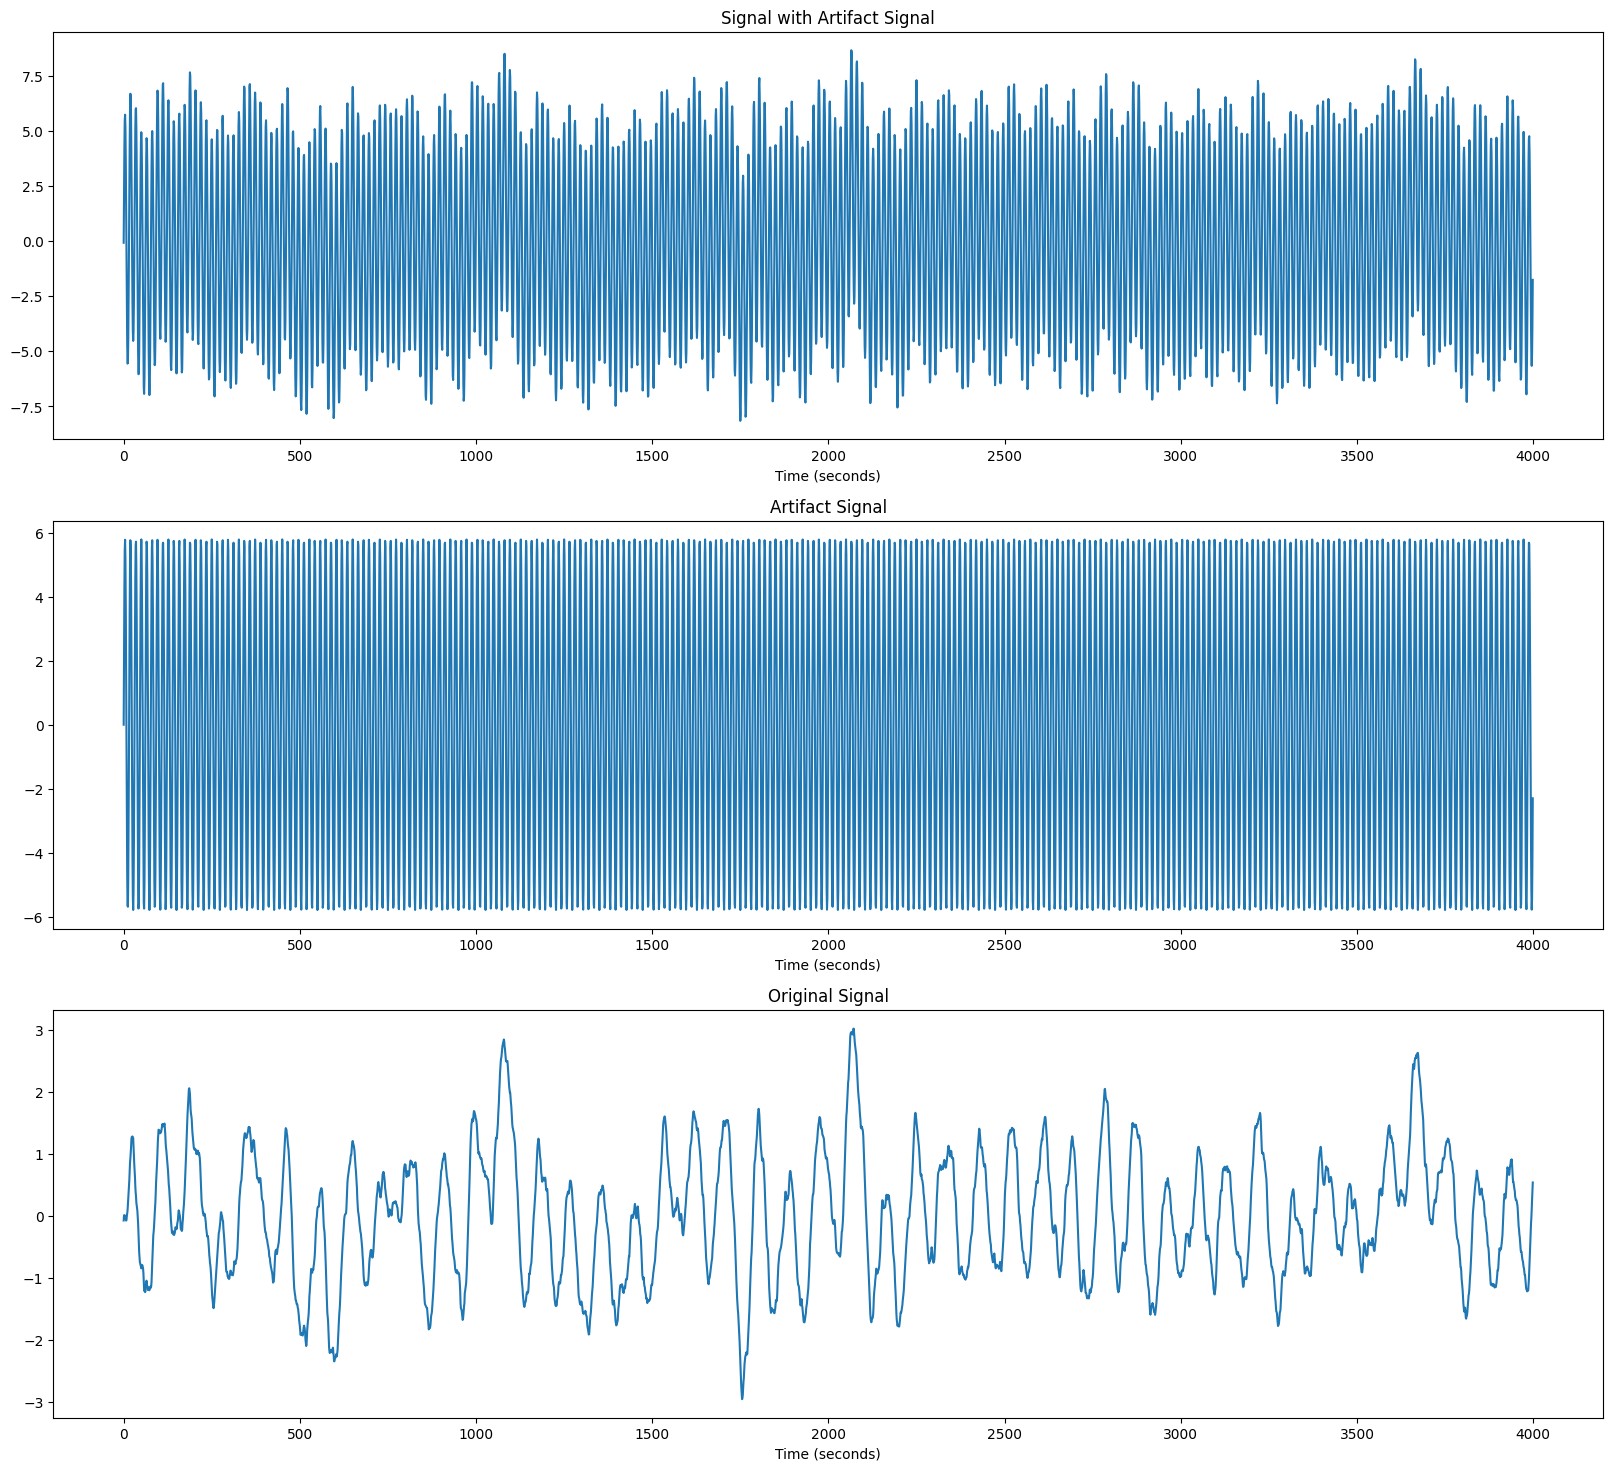

In [4]:
plt.figure(figsize=(20,18))
plt.subplot(3, 1, 1)
plt.plot(sig_with_artifact[0])
plt.xlabel("Time (seconds)")
plt.title('Signal with Artifact Signal')

plt.subplot(3, 1, 2)
plt.plot(artifact[0])
plt.xlabel("Time (seconds)")
plt.title('Artifact Signal')

plt.subplot(3, 1, 3)
plt.plot(sig[0])
plt.xlabel("Time (seconds)")
plt.title('Original Signal')

In [14]:
# MinMaxScaler를 이용하여 정규화
scaler = MinMaxScaler()
X = scaler.fit_transform(sig_with_artifact)
y = scaler.fit_transform(sig)

print(X.shape)
print(y.shape)

(1000, 4000)
(1000, 4000)


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape: {}, y_train shape: {}".format(X_train.shape, y_train.shape)) # x : B x T, y : B x T
print("X_test shape: {}, y_test shape: {}".format(X_test.shape, y_test.shape))

# 차원 추가 (MLP는 마지막 차원 추가)
X_train = X_train.reshape(X_train.shape[0], 4000, 1) # B x T x 1
X_test = X_test.reshape(X_test.shape[0], 4000, 1)

print("unsqueezed X_train shape: {}, y_train shape: {}".format(X_train.shape, y_train.shape)) # x : B x T x 1, y : B x T
print("unsqueezed X_test shape: {}, y_test shape: {}".format(X_test.shape, y_test.shape))

# TensorDataset을 사용하여 데이터셋 생성
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

X_train shape: (800, 4000), y_train shape: (800, 4000)
X_test shape: (200, 4000), y_test shape: (200, 4000)
unsqueezed X_train shape: (800, 4000, 1), y_train shape: (800, 4000)
unsqueezed X_test shape: (200, 4000, 1), y_test shape: (200, 4000)


In [7]:
# DNN 모델 정의
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(in_features=X_train.shape[2], out_features=256)
        self.drop = nn.Dropout(0.25)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=64)
        self.fc4 = nn.Linear(in_features=64, out_features=1)

    def forward(self, input_data):
        x = F.relu(self.fc1(input_data))
        x = self.drop(x)
        x = F.relu(self.fc2(x))
        x = self.drop(x)
        x = F.relu(self.fc3(x))
        x = self.drop(x)
        x = self.fc4(x).squeeze(-1)
        return x

# 심층 신경망에서 필요한 파라미터 정의
learning_rate = 0.001
model = MLP().to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate);
print(model)


MLP(
  (fc1): Linear(in_features=1, out_features=256, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=1, bias=True)
)


In [8]:
# 모델 학습
num_epochs = 200

for epoch in range(num_epochs):
    for batch in train_loader:
        x = batch[0] # x : B x T x 1
        y = batch[1] # y : B x T
        x, y = x.to(device), y.to(device)

        # Forward pass
        y_pred = model(x) # y_pred : B x T
        loss = criterion(y_pred, y)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch+1)%5 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')


Epoch 5/200, Loss: 0.006862077862024307
Epoch 10/200, Loss: 0.005131166893988848
Epoch 15/200, Loss: 0.0041084494441747665
Epoch 20/200, Loss: 0.0036610872484743595
Epoch 25/200, Loss: 0.0032553214114159346
Epoch 30/200, Loss: 0.0029288316145539284
Epoch 35/200, Loss: 0.002653952222317457
Epoch 40/200, Loss: 0.00240101246163249
Epoch 45/200, Loss: 0.0022039958275854588
Epoch 50/200, Loss: 0.0019864311907440424
Epoch 55/200, Loss: 0.001780097372829914
Epoch 60/200, Loss: 0.0016318474663421512
Epoch 65/200, Loss: 0.001475240453146398
Epoch 70/200, Loss: 0.0013399625895544887
Epoch 75/200, Loss: 0.001198174781166017
Epoch 80/200, Loss: 0.0010966173140332103
Epoch 85/200, Loss: 0.0010076956823468208
Epoch 90/200, Loss: 0.0009232140146195889
Epoch 95/200, Loss: 0.0008641037275083363
Epoch 100/200, Loss: 0.0008039779495447874
Epoch 105/200, Loss: 0.0007574167684651911
Epoch 110/200, Loss: 0.0007112492457963526
Epoch 115/200, Loss: 0.000674351816996932
Epoch 120/200, Loss: 0.00064014689996838

In [9]:
# 모델 평가
gt = torch.tensor([])
pred = torch.tensor([])

model.eval()
with torch.no_grad():
    for batch in test_loader:
        x = batch[0] # x : B x T x 1
        y = batch[1] # y : B x T
        x, y = x.to(device), y.to(device)

        y_pred = model(x) # y_pred : B x T
        
        pred = torch.cat((pred, y_pred.cpu()), 0)
        gt = torch.cat((gt, y.cpu()), 0)

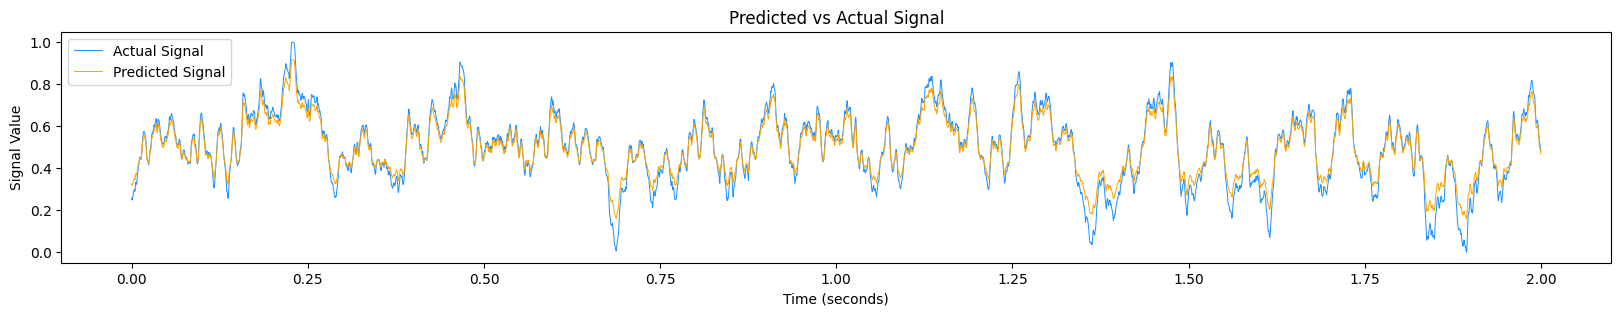

Mean Absolute Error: 0.030311407521367073
Mean Squared Error: 0.0015792043413966894


In [12]:
# time domain plotting

predicted_signal = pred[0]
actual_signal = gt[0]

t = np.linspace(0, 2, num=4000)  

plt.figure(figsize=(20, 3))
plt.plot(t, actual_signal, label='Actual Signal', color='dodgerblue', alpha=1, linewidth=0.7)
plt.plot(t, predicted_signal, label='Predicted Signal', color='orange', alpha=1, linewidth=0.7)
plt.xlabel('Time (seconds)')
plt.ylabel('Signal Value')
plt.title('Predicted vs Actual Signal')
plt.legend()
plt.show()

print(f"Mean Absolute Error: {mean_absolute_error(actual_signal, predicted_signal)}")
print(f"Mean Squared Error: {mean_squared_error(actual_signal, predicted_signal)}")

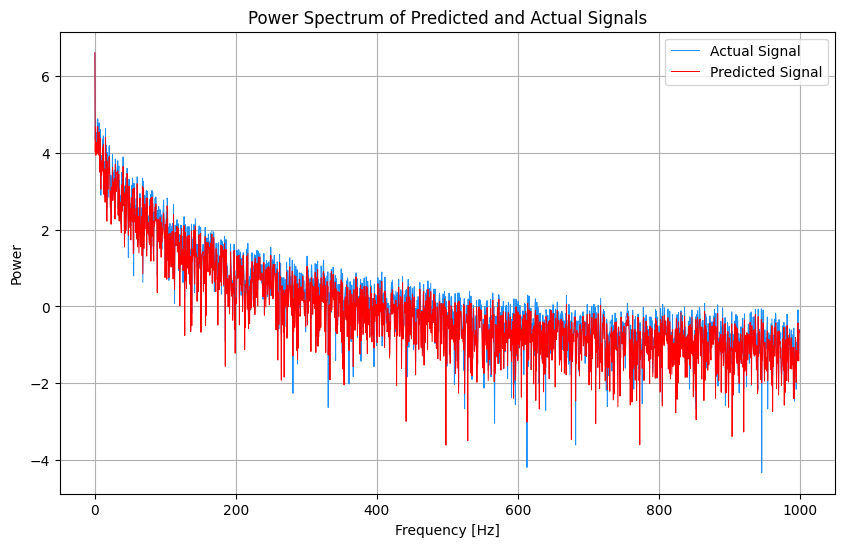

Mean Absolute Error: 0.26755262125897056
Mean Squared Error: 0.12106948749450465


In [13]:
# frequency domain plotting

n = len(predicted_signal)

fs = 2000
freqs = np.fft.fftfreq(n, d=1/fs)[:n//2]

fft_predicted = np.fft.fft(predicted_signal)
fft_predicted = np.abs(fft_predicted[:n//2])
fft_predicted[1:] = 2 * fft_predicted[1:]
power_predicted = fft_predicted**2

fft_actual = np.fft.fft(actual_signal)
fft_actual = np.abs(fft_actual[:n//2])
fft_actual[1:] = 2 * fft_actual[1:]
power_actual = fft_actual**2

# 결과 플로팅
plt.figure(figsize=(10, 6))
plt.plot(freqs, np.log10(power_actual), label='Actual Signal', color='dodgerblue', alpha=1, linewidth=0.7)
plt.plot(freqs, np.log10(power_predicted), label='Predicted Signal', color='red', alpha=1, linewidth=0.7)
plt.title('Power Spectrum of Predicted and Actual Signals')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power')
plt.legend()
plt.grid(True)
plt.show()

print(f"Mean Absolute Error: {mean_absolute_error(np.log10(power_predicted), np.log10(power_actual))}")
print(f"Mean Squared Error: {mean_squared_error(np.log10(power_predicted), np.log10(power_actual))}")